Dependencies

In [2]:
#dependencies
import random
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.optimizers import RMSprop, Adam
import gym


Using TensorFlow backend.


Q(state, action) = R(state, action) + Gamma * Max[Q(next state, all actions)]

The Gamma parameter has a range of 0 to 1 (0 <= Gamma > 1).  If Gamma is closer to zero, the agent will tend to consider only immediate rewards.  If Gamma is closer to one, the agent will consider future rewards with greater weight, willing to delay the reward.

epsilon parameter determines with which probability our agent takes a random action

## First model
first model 

In [5]:
class Agent:
    def __init__(self, envName=('CartPole-v0'), gamma=None, epsilon=None, e_decay=0.995, learning_rate=0.001):
        self.envName = envName
        self.env = gym.make(envName)
        self.memory = deque(maxlen=10000)
        self.gamma = gamma
        self.epsilon = epsilon
        self.e_decay = e_decay
        self.e_min = 0.02  # minimal exploraton rate
        self.learning_rate = learning_rate
        self.model = self._build_model()

    def _build_model(self):
        '''
        builds a neural network
        :return: model - neural network object
        '''
        model = Sequential()
        model.add(Dense(24, input_dim=self.env.observation_space.shape[0], activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.env.action_space.n, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        '''
        add <s,a,r,s'> vector to memory
        :param state: agent state
        :param action: action to perform
        :param reward: reward given after performed action
        :param next_state: next state
        :param done: bool parameter which determines whrther current state terminal or not
        :return: 
        '''
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        '''
        defines gow agent will actin a given state
        :param state: state of our agent
        :return: action to be perfomed
        '''
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.env.action_space.n)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        '''
        train network by sampling elements from memory
        :param batch_size: sample size of agent memory
        :return: 
        '''
        batch_size = min(batch_size, len(self.memory))
        minibatch = random.sample(self.memory, batch_size)
        X = np.zeros((batch_size, self.env.observation_space.shape[0]))
        Y = np.zeros((batch_size, self.env.action_space.n))
        for i in range(batch_size):
            state, action, reward, next_state, done = minibatch[i]
            target = self.model.predict(state)[0]
            # print "i", i, " predict", self.model.predict(state)
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            X[i], Y[i] = state, target
        self.model.fit(X, Y, batch_size=batch_size, nb_epoch=1, verbose=0)
        if self.epsilon > self.e_min:
            self.epsilon *= self.e_decay

    def load(self, name):
        '''
        load weights from a file
        :param name: filename
        :return: 
        '''
        self.model.load_weights(name)

    def save(self, name):
        '''
        seves weights to a file
        :param name: filename
        :return: 
        '''
        self.model.save_weights(name)


### Cartpole

In [21]:
agent = Agent('CartPole-v0',.95,1.0)
# Iterate the game
#####################################
#uncomment if u want to load weights#
#####################################
# agent.model.load_weights("cartpole3.kek")

#####################################
#uncomment if u want to save scores#
#####################################
f = open('data/CartpoleFirstModel.txt', 'w')

for e in range(3000):
    state = agent.env.reset()
    state_size = agent.env.observation_space.shape[0]
    state = np.reshape(state, [1,state_size])
    resultReward = 0
    while True:
        agent.env.render()
        action = agent.act(state)
        next_state, reward, done, _ = agent.env.step(action)
        # reward = reward if not done else -1
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        resultReward += reward
        if done and resultReward <= 190:
            reward = -1
        else:
            reward = reward
        if done:
            if resultReward > 180:
                print 'episode ', e, ' score: ', resultReward
            print >> f, resultReward #, 'ep', e
            break
    agent.replay(64)
    if e % 10 == 0:
         agent.save("cartpoleFirstModelWeights.kek")
f.close()

[2017-10-17 23:43:32,015] Making new env: CartPole-v0


episode  528  score:  182.0
episode  687  score:  200.0
episode  823  score:  188.0
episode  842  score:  200.0
episode  859  score:  200.0
episode  862  score:  189.0
episode  1057  score:  200.0
episode  1084  score:  200.0
episode  1129  score:  200.0
episode  1151  score:  200.0
episode  1186  score:  200.0
episode  1207  score:  200.0
episode  1259  score:  200.0
episode  1303  score:  200.0
episode  1323  score:  200.0
episode  1324  score:  200.0
episode  1334  score:  200.0
episode  1347  score:  200.0
episode  1397  score:  200.0
episode  1409  score:  200.0
episode  1413  score:  200.0
episode  1441  score:  200.0
episode  1516  score:  194.0
episode  1681  score:  200.0
episode  1735  score:  200.0
episode  1759  score:  200.0
episode  1794  score:  200.0
episode  1795  score:  200.0
episode  1797  score:  200.0
episode  1800  score:  200.0
episode  1809  score:  200.0
episode  1814  score:  200.0
episode  1815  score:  200.0
episode  1823  score:  200.0
episode  1826  score

### Mountain Car

In [14]:
agent = Agent('MountainCar-v0',1.,1.0,0.9995,0.0001)
# Iterate the game
f=open('mountainCarFirstModel.txt','w')
for e in range(10000):
    state = agent.env.reset()
    state_size = agent.env.observation_space.shape[0]
    state = np.reshape(state, [1,state_size])
    resultReward = 0
    while True:
        agent.env.render()
        action = agent.act(state)
        next_state, reward, done, _ = agent.env.step(action)
        # reward = reward if not done else -1
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        resultReward += reward
        if done:
            if resultReward > -200:
                print 'ep', e , 'score', resultReward
            print >> f, resultReward
            break
    agent.replay(64)

    if e % 50 == 0:
        agent.save("MountainCarFirstModelWeights.kek")
f.close()


[2017-10-17 13:31:50,313] Making new env: MountainCar-v0


# Second model

In [16]:
class Agent2:
    def __init__(self, state_size, action_size):
        self.render = True

        self.state_size = state_size
        self.action_size = action_size

        self.memory = deque(maxlen=10000) #memory size
        self.discount_factor = 0.99
        self.epsilon = 1.0
        self.e_min = 0.005
        self.e_decay = 0.00002
        self.train_start = 1000

        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

    def build_model(self):
        '''
        build neural net
        :return: model - neural net object
        '''
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=0.001))
        return model

    def update_target_model(self):
        '''
        update weights of our target model
        :return:
        '''
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        '''
        perform agent action in a given state
        :param state: agent state
        :return:
        '''
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    def remember(self, state, action, reward, next_state, done):
        '''
        add <s,a,r,s'> vector to agent memory
        :param state: agent state
        :param action: action to perform
        :param reward: collected reward
        :param next_state: next state after performing actopn
        :param done: bool variable which determines is current state terminal or not
        :return:
        '''
        if action == 2:
            action = 1
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.e_min:
            self.epsilon -= self.e_decay
        # print(len(self.memory))

    def replay(self, batch_size):
        '''
        train network by sampling elements from memory
        :param batch_size:
        :return:
        '''
        if len(self.memory) < self.train_start:
            return
        batch_size = min(batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        update_input = np.zeros((batch_size, self.state_size))
        update_target = np.zeros((batch_size, self.action_size))

        for i in range(batch_size):
            state, action, reward, next_state, done = mini_batch[i]
            target = self.model.predict(state)[0]

            if done:
                target[action] = reward
            else:
                target[action] = reward + self.discount_factor * \
                                          np.amax(self.target_model.predict(next_state)[0])
            update_input[i] = state
            update_target[i] = target

        self.model.fit(update_input, update_target, batch_size=batch_size, epochs=1, verbose=0)

    def load(self, name):
        '''
        loadweights of pre-trained network
        :param name: filename to load
        :return:
        '''
        self.model.load_weights(name)

    def save(self, name):
        '''
        store network weights
        :param name: filename to save
        :return:
        '''
        self.model.save_weights(name)



### Cartpole

In [19]:
env = gym.make('CartPole-v0')
state_size = env.observation_space.shape[0]
#action_size = env.action_space.n
# reduce action size for mountain car problem
action_size = 2
agent = Agent2(state_size, action_size)
# agent.load("./save/MountainCar1.kek")
# uncomment to save scores to a file
f= open('scoresCartpoleSecondModel.txt', 'w')
for e in range(3000):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    # print(state)


    while not done:
        if agent.render:
            env.render()
        action = agent.act(state)

        next_state, reward, done, info = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        #reward = reward if not done else -100

        agent.remember(state, action, reward, next_state, done)
        score += reward
        state = next_state

        if done:
            env.reset()
            agent.update_target_model()
            # print ony successful episodes
            if score > 180:
                print "episode:", e, "  score:", score
            # uncomment to save scores to a file
            print >> f, score
    agent.replay(64)

    # save model weights every 30 iterations
    if e % 10 == 0:
        agent.save("cartpolesecondModel.kek")
# file close, uncomment if you want to use file
f.close()

[2017-10-17 23:10:14,265] Making new env: CartPole-v0


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_41 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 34        
Total params: 722
Trainable params: 722
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_44 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_45 (De

### mountain car

In [ ]:
env = gym.make('MountainCar-v0')
state_size = env.observation_space.shape[0]
#action_size = env.action_space.n
# reduce action size for mountain car problem
action_size = 2
agent = Agent2(state_size, action_size)
# agent.load("./save/MountainCar1.kek")
# uncomment to save scores to a file
#f= open('scoresCar1.txt', 'w')
for e in range(100000):
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    # print(state)

    take_action = 0

    action_count = 0

    while not done:
        if agent.render:
            env.render()

        action_count = action_count + 1

        if action_count == 4:
            action = agent.act(state)
            action_count = 0

            if action == 0:
                take_action = 0
            elif action == 1:
                take_action = 2

        next_state, reward, done, info = env.step(take_action)
        next_state = np.reshape(next_state, [1, state_size])
        #reward = reward if not done else -100

        agent.remember(state, take_action, reward, next_state, done)
        agent.replay(64)
        score += reward
        state = next_state

        if done:
            env.reset()
            agent.update_target_model()
            # print ony successful episodes
            if score > -200:
                print "episode:", e, "  score:", score
            # uncomment to save scores to a file
            #print >> f,"episode:", e, "  score:", score
    # save model weights every 50 iterations
    if e % 50 == 0:
        agent.save("MountainCar1.kek")
# file close, uncomment if you want to use file
# f.close()

# Results

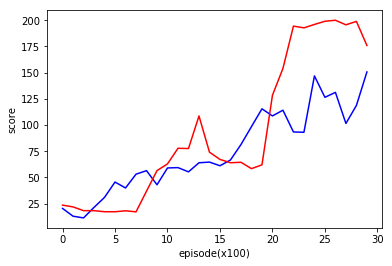

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

with open("data/CartPoleFirstModel.txt") as f:
    first = np.array([float(i) for i in f.read().split()])
with open("data/scoresCartpoleSecondModel.txt") as f:
    second = np.array([float(i) for i in f.read().split()])

first = np.mean(first.reshape(-1,100), axis =1)
second = np.mean(second.reshape(-1,100), axis =1)

plt.plot(first, "b", label="first")
plt.plot(second, "r", label = "second")
plt.ylabel('score')
plt.xlabel('episode(x100)')
plt.show()



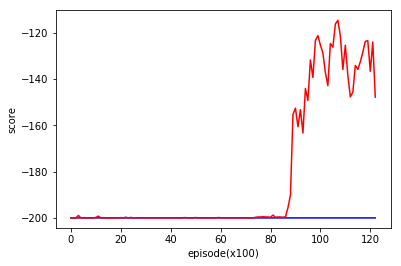

In [25]:

with open("data/mountainCarFirstModel.txt") as f:
    first = np.array([float(i) for i in f.read().split()])
with open("data/scoresCarSecondModel.txt") as f:
    second = np.array([float(i) for i in f.read().split()])

if first.shape[0] != second.shape[0]:

    diff = second.shape[0] - first.shape[0]
    first = list(first)
    first.extend([-200] * diff)
    first = np.array(first)

first = np.mean(first.reshape(-1,100), axis =1)
second = np.mean(second.reshape(-1,100), axis =1)

plt.plot(first, "b")
plt.plot(second, "r")
plt.ylabel('score')
plt.xlabel('episode(x100)')
plt.show()